In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

def get_feature_matrix(masstime, data, significant=True):
    if not significant:
        return data.iloc[3:,8:].to_numpy(dtype=float).T
    inds=[]
    for i in range(3,data.shape[0]):
        mt=data.iloc[i,4] + '@' + data.iloc[i,5]
        if mt in masstime:
            inds.append(i)
    inds=np.asarray(inds, dtype=int)
    return data.iloc[inds,8:].to_numpy(dtype=float).T

def get_features(masstime, data, significant=True):
    if not significant:
        return data
    inds=[0,1,2]
    for i in range(3,data.shape[0]):
        mt=data.iloc[i,4] + '@' + data.iloc[i,5]
        if mt in masstime:
            inds.append(i)
    inds=np.asarray(inds, dtype=int)
    return data.iloc[inds,:]


def get_ids(data):
    ID=[]
    for line in data.iloc[2,8:]:
        ID.append(line.split('_')[-1].split('.')[0])
    return np.array(ID)

def add_noise(x, magnitude):
    return x + np.random.normal(0,magnitude, x.shape)

In [13]:
path_s = "../../PDproj/cellresults/ttest/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s = [line.split('\n')[0] for line in open(path_s + "filenames.txt")]
filenames_s

['cellshilicneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellshilicpos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidomicsneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidomicspos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPpos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumHILICneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumHILICpos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPpos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv']

In [14]:
path_s2 = "../../PDproj/cellresults/ttest/withGF/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s2 = [line.split('\n')[0] for line in open(path_s2 + "filenames.txt")]
filenames_s2

['cellshilicnegALPHA0.05FC1.0MINVAR0.125.csv',
 'cellshilicposALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidnegALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidposALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPnegALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPposALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumhilicnegALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumhilicposALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPnegALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPposALPHA0.05FC1.0MINVAR0.125.csv']

In [15]:
path = "../../PDproj/celldata/clean/"
filenames = [line.split('\n')[0] for line in open(path + "filenames.txt")]
filenames

['cellshilicneg_log2.csv',
 'cellshilicpos_log2.csv',
 'cellslipidomicsneg_log2.csv',
 'cellslipidomicspos_log2.csv',
 'cellsRPneg_log2.csv',
 'cellsRPpos_log2.csv',
 'mediumHILICneg_log2.csv',
 'mediumHILICpos_log2.csv',
 'mediumRPneg_log2.csv',
 'mediumRPpos_log2.csv']

In [59]:
fnum=3 # 2 is good example
data = pd.read_csv(path + filenames[fnum], sep=';', header=None)
tle = filenames[fnum].split('_')[0]
df = pd.read_csv(path_s + filenames_s[fnum],sep=';')
df_GF = pd.read_csv(path_s2 + filenames_s2[fnum],sep=';')

In [60]:
print(filenames[fnum])
print(filenames_s[fnum])
print(filenames_s2[fnum])

cellslipidomicspos_log2.csv
cellslipidomicspos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv
cellslipidposALPHA0.05FC1.0MINVAR0.125.csv


### Get significant features with GAP status

In [49]:
pathGF = "../../PDproj/celldata/datawithGFstatus/clean/"
filenamesGF = [line.split('\n')[0] for line in open(pathGF + "filenames.txt")]
GF = pd.read_csv(pathGF + filenamesGF[fnum],sep=';', header=None)
cls = GF.iloc[0,8:48]

masstime = df_GF[' masstime'].to_numpy()
GF=get_features(masstime, GF, True)
keep = [i for i in range(0,GF.shape[1]) if i not in np.arange(8,88)]
GF=GF.iloc[:,keep]

In [51]:
aSYN=GF.iloc[:,8:18]
comb=GF.iloc[:,18:28]
INFg=GF.iloc[:,28:38]
UT=GF.iloc[:,38:]

In [60]:
tol=10
token=8
inds=[]
ls=['aSYN','comb','INFg','UT']
for k, group in enumerate([aSYN,comb,INFg,UT]):
    for i in range(3,group.shape[0]):
        arr=np.asarray(group.iloc[i,:], dtype=int)
        s=np.sum(arr==token)
        if s>=tol:
            inds.append((ls[k],i))

In [61]:
inds

[('UT', 406)]

In [62]:
pd.DataFrame(np.stack((GF.iloc[inds[0][1],8:], cls), axis=1))

,0,1
0,8,aSYN
1,128,aSYN
2,32,aSYN
3,8,aSYN
4,32,aSYN
5,32,aSYN
6,8,aSYN
7,32,aSYN
8,8,aSYN
9,128,aSYN


### Get significant features by matching masstimes

In [61]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aSYN,aSYN,...,UT,UT,UT,UT,UT,UT,UT,UT,UT,UT
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,9,...,6,11,15,17,24,28,37,39,42,45
2,Name,Formula,Annot. DeltaMass [ppm],Calc. MW,m/z,RT [min],MS2,Reference Ion,Area: 221031_SL_Solu_Lipidi_pos_0022.raw (F20),Area: 221031_SL_Solu_Lipidi_pos_0026.raw (F24),...,Area: 221031_SL_Solu_Lipidi_pos_0023.raw (F21),Area: 221031_SL_Solu_Lipidi_pos_0028.raw (F26),Area: 221031_SL_Solu_Lipidi_pos_0033.raw (F31),Area: 221031_SL_Solu_Lipidi_pos_0034.raw (F32),Area: 221031_SL_Solu_Lipidi_pos_0042.raw (F40),Area: 221031_SL_Solu_Lipidi_pos_0046.raw (F44),Area: 221031_SL_Solu_Lipidi_pos_0053.raw (F51),Area: 221031_SL_Solu_Lipidi_pos_0055.raw (F53),Area: 221031_SL_Solu_Lipidi_pos_0058.raw (F56),Area: 221031_SL_Solu_Lipidi_pos_0061.raw (F59)
3,Locustol,C9 H12 O2,0.19,152.08376,153.09103,3.196,DDA for preferred ion,[M+H]+1,21.5121549448339,21.4746055343211,...,21.308044881936,21.7245216015449,21.6292650464469,22.0231531260167,21.9426964137303,21.2713111063914,21.6074902185448,21.4169468102385,21.8943911629971,21.3672395225328
4,"2,6-Dioxo(4-~14~C)-1,2,3,6-tetrahydro-4-pyrimi...",C4 [14]C H4 N2 O4,0.96,158.0205,159.02778,0.643,DDA for preferred ion,[M+H]+1,19.907024097623,19.8469039901301,...,19.3230595530306,16.4559465651049,18.8605503575636,19.5323735697553,17.8498050793163,16.1039287915096,16.7310567331204,17.0202763827131,17.3905257336149,18.8759688440033


In [64]:
masstime = df[' masstime'].to_numpy()
groups=data.iloc[0,8:]
labels = LabelEncoder().fit_transform(groups)
ID=get_ids(data)
x=get_feature_matrix(masstime, data, True)
assert(x.shape[0]==40)

In [71]:
pca = PCA().fit_transform(x)
pca = add_noise(pca, 1)

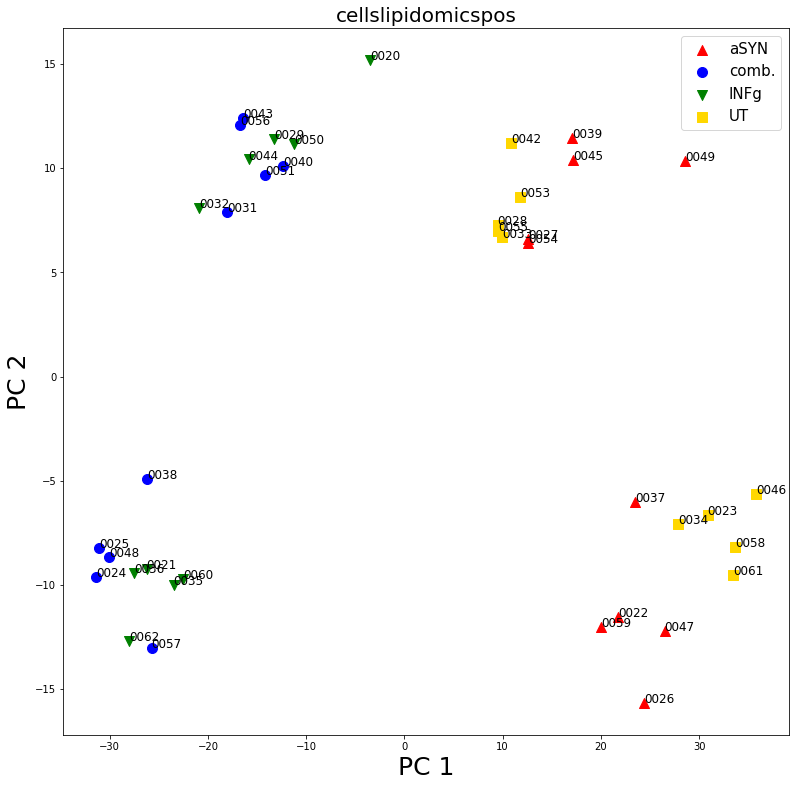

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [73]:
SAVE=True
k=1
fig, ax = plt.subplots(figsize=(13,13))
ax.scatter(pca[:10,0],pca[:10,k], marker='^', c='red', s=100)
ax.scatter(pca[10:20,0],pca[10:20,k], marker='o', c='blue', s=100)
ax.scatter(pca[20:30,0],pca[20:30,k], marker='v', c='green', s=100)
ax.scatter(pca[30:,0],pca[30:,k], marker='s', c='gold', s=100)
ax.legend(['aSYN','comb.','INFg','UT'], fontsize=15)

for i, txt in enumerate(ID):
    ax.annotate(txt, (pca[i,0], pca[i,k]),fontsize=12)
plt.xlabel('PC 1', fontsize=25)
plt.ylabel('PC {}'.format(k+1), fontsize=25)
plt.title(tle, fontsize=20)
plt.show()

if SAVE:
    fig.savefig('../../PDproj/paavo/plots/pca/eps/{}.eps'.format(tle))
    fig.savefig('../../PDproj/paavo/plots/pca/tifs/{}.tif'.format(tle))
    fig.savefig('../../PDproj/paavo/plots/pca/jpeg/{}.jpg'.format(tle))